In [1]:
%matplotlib inline

import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

plt.style.use('seaborn-whitegrid')

In [2]:
def summarize(alpha=0.05):

    def _summarize(ser):
        hpd_ = pm.hpd(ser, alpha=alpha)
        return pd.Series({
            'mean_': ser.mean(),
            'lower': hpd_[0],
            'upper': hpd_[1],
        })

    return _summarize


def agg_prediction(trace_var, source_data, group_columns, aggregate_fc):
    df = pd.DataFrame(trace_var).stack().reset_index()
    merged = pd.merge(
        df, source_data,
        left_on='level_1', right_index=True
    )

    return (
        merged.groupby(group_columns)[0].apply(aggregate_fc)
        .unstack().sort_index().reset_index()
    )


**10H4** The data contained in `data(salamanders)` are counts of salamanders (*Plethodon elongatus*) from 47 different 49-m2 plots in northern California.146 The column `salamanders` is the count in each plot, and the columns `coverage` and `forest_age` are percent of ground cover and age of trees in the plot, respectively. You will model `salamanders` as a Poisson variable.


In [3]:
data = pd.read_csv('../data/salamanders.csv', sep=';')
data.columns = ['site', 'salamanders', 'coverage', 'forest_age']
data.sample(5)

,site,salamanders,coverage,forest_age
45,46,0,89,60
0,1,13,85,316
27,28,1,88,105
32,33,0,5,2
33,34,0,8,10


(a) Model the relationship between density and percent cover, using a log-link (same as the example in the book and lecture). Use weakly informative priors of your choosing. Plot the expected counts and their 89% interval against percent cover. In which ways does the model do a good job? In which ways does it do a bad job?


In [18]:
test = pd.DataFrame(
    [[coverage, forest_age]
     for coverage in range(0, 100, 3)
     for forest_age in np.linspace(data.forest_age.min(), data.forest_age.max(), 30)],
    columns=['coverage', 'forest_age']
)

In [20]:
with pm.Model() as model_cover:
    alpha = pm.Normal('alpha', mu=0, sd=2)
    beta = pm.Normal('beta', mu=0, sd=2)

    mean_ = np.log1p(data.salamanders.values).mean()
    
    def get_lambda(df):
        log_lambda = mean_ + alpha + beta * (df.coverage.values / 100)
        return pm.math.exp(log_lambda)

    lam = pm.Deterministic('lam', get_lambda(data))
    
    salamanders = pm.Poisson('salamanders', mu=lam,
                             observed=data.salamanders.values)

    lam_test = pm.Deterministic('lam_test', get_lambda(test))
    
    model_cover.name = 'coverage'
    model_cover.trace = pm.sample(5000, tune=2000, chains=2)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 14000/14000 [00:18<00:00, 767.27draws/s]
The number of effective samples is smaller than 25% for some parameters.


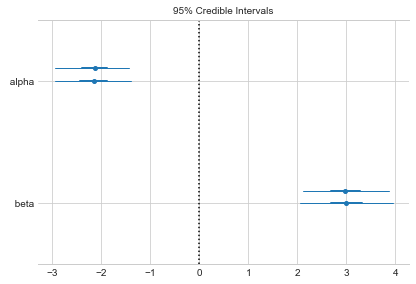

In [21]:
pm.forestplot(model_cover.trace, varnames=['alpha', 'beta'], rhat=False)
None

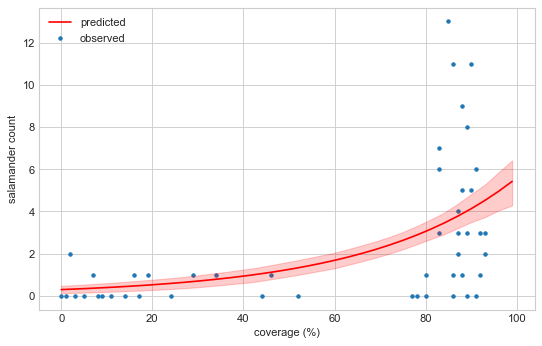

In [26]:
tmp = agg_prediction(model_cover.trace['lam_test'], test, ['coverage'], summarize(.11))

fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=80)

ax.scatter(data.coverage, data.salamanders, marker='.',
           label='observed')
ax.plot(tmp.coverage, tmp.mean_, color='r', label='predicted')
ax.fill_between(tmp.coverage, tmp.lower, tmp.upper,
               alpha=.2, color='r')
ax.legend()
ax.set(xlabel='coverage (%)', ylabel='salamander count')
None

(b) Can you improve the model by using the other predictor, `forest_age`? Try any models you think useful. Can you explain why `forest_age` helps or does not help with prediction?

In [41]:
with pm.Model() as model_cover_forest:
    alpha = pm.Normal('alpha', mu=0, sd=2)
    beta = pm.Normal('beta', mu=0, sd=2)
    beta_f = pm.Normal('beta_f', mu=0, sd=2)

    mean_ = np.log1p(data.salamanders.values).mean()
    
    def get_lambda(df):
        log_lambda = (
            mean_
            + alpha
            + (beta + beta_f * (df.forest_age.values / df.forest_age.max()))
                * (df.coverage.values / 100)
        )

        return pm.math.exp(log_lambda)
    
    lam = pm.Deterministic('lam', get_lambda(data))
    
    salamanders = pm.Poisson(
        'salamanders',
        mu=lam,
        observed=data.salamanders.values
    )

    lam_test = pm.Deterministic('lam_test', get_lambda(test))
    
    model_cover_forest.name = 'coverage & forest'
    model_cover_forest.trace = pm.sample(5000, tune=2500, chains=2)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_f, beta, alpha]
Sampling 2 chains: 100%|██████████| 15000/15000 [00:32<00:00, 464.11draws/s]
The acceptance probability does not match the target. It is 0.879987611071589, but should be close to 0.8. Try to increase the number of tuning steps.


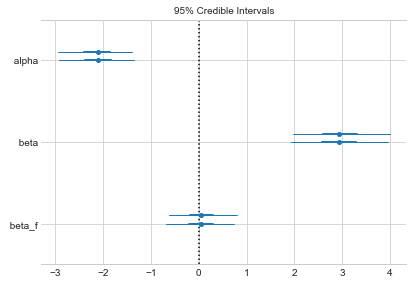

In [42]:
pm.forestplot(model_cover_forest.trace, varnames=['alpha', 'beta', 'beta_f'], rhat=False)
None

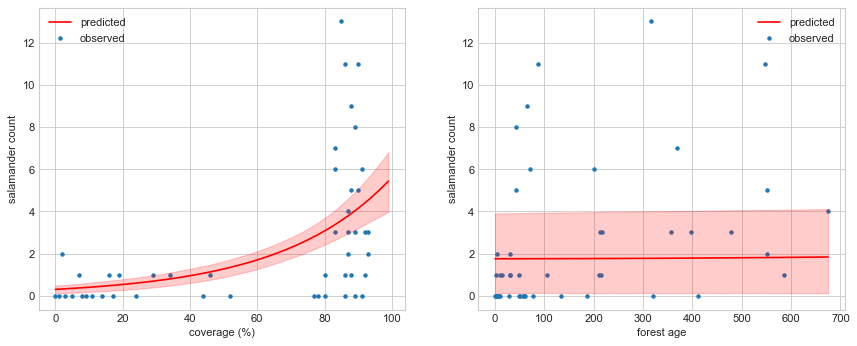

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5), dpi=80)

tmp = agg_prediction(model_cover_forest.trace['lam_test'], test,
                     ['coverage'], summarize(.11))

ax1.scatter(data.coverage, data.salamanders, marker='.',
           label='observed')
ax1.plot(tmp.coverage, tmp.mean_, color='r', label='predicted')
ax1.fill_between(tmp.coverage, tmp.lower, tmp.upper,
               alpha=.2, color='r')
ax1.legend()
ax1.set(xlabel='coverage (%)', ylabel='salamander count')


tmp = agg_prediction(model_cover_forest.trace['lam_test'], test,
                     ['forest_age'], summarize(.11))

ax2.scatter(data.forest_age, data.salamanders, marker='.',
           label='observed')
ax2.plot(tmp.forest_age, tmp.mean_, color='r', label='predicted')
ax2.fill_between(tmp.forest_age, tmp.lower, tmp.upper,
               alpha=.2, color='r')
ax2.legend()
ax2.set(xlabel='forest age', ylabel='salamander count')

None

In [44]:
comparison = pm.compare({
        model_cover: model_cover.trace,
        model_cover_forest: model_cover_forest.trace,
    },
    method='BB-pseudo-BMA'
)

comparison

/home/petrushev/etc/jup_env/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/home/petrushev/etc/jup_env/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
coverage,213.19,4.5,0,0.87,25.31,0,1
coverage & forest,217.24,7.18,4.05,0.13,25.92,1.34,1
